# Diagnostic médical par radiographie du thorax avec apprentissage profond

<img src="images/xray-header-image.png" style="padding-top: 50px;width: 87%;left: 0px;margin-left: 0px;margin-right: 0px;">


Dans ce travail, on va explorer le diagnostic d'images médicales en construisant un classificateur de radiographie thoracique à la pointe de la technologie en utilisant Keras. 

Cela nous permettra de suivre certaines des étapes de la construction et de l'évaluation d'un modèle de classification par apprentissage profond. En particulier, on devra:

- Prétraiter et préparer un jeu de données de rayons X du monde réel.
- Utiliser l'apprentissage par transfert pour réentraîner un modèle DenseNet pour la classification d'images radiologiques.
- Apprendre une technique pour gérer le déséquilibre des classes
- Mesurer la performance de diagnostic en calculant l'AUC (Area Under the Curve) pour la courbe ROC (Receiver Operating Characteristic).
- Visualisez l'activité du modèle à l'aide de GradCAMs.

En réalisant ce travail, on abordera les sujets suivants : 

- Préparation des données.
  - Visualisation des données.
  - Prévention des fuites de données.
- Développement du modèle
  - Traitement du déséquilibre des classes.
  - Exploiter les modèles pré-entraînés en utilisant l'apprentissage par transfert.
- Évaluation
  - Courbes AUC et ROC.

## Plan

- [1. Import des Packages et Fonctions](#1)
- [2. Chargement des Données](#2)
    - [2.1 Charger les données](#2-1)
    - [2.2 Prévention des fuites de données (Data Leakage)](#2-2)
    - [2.3 Préparation des Images](#2-3)
- [3. Développement du modèle](#3)
    - [3.1 Traitement déséquilibre des Classes](#3-1)
    - [3.2 DenseNet121](#3-2)
- [4. Apprentissage)](#4)
    - [4.1 Entrainement sur un grand ensemble de données](#4-1)
- [5. Prédiction et Evaluation](#5)
    - [5.1 Courbe ROC et AUROC](#5-1)
    - [5.2 Visualisation apprentissage avec GradCAM](#5-2)

<a name='1'></a>
## 1. Import des Packages et Fonctions

Nous allons utiliser les paquets suivants :
- `numpy` et `pandas` sont ceux que nous utiliserons pour manipuler nos données.
- `matplotlib.pyplot` et `seaborn` seront utilisés pour produire des tracés pour la visualisation
- `util` fournira les fonctions utilitaires définies localement qui ont été fournies pour ce travail.

Nous utiliserons également plusieurs modules du cadre `keras` pour construire des modèles d'apprentissage profond.

In [1]:
import until

In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
import util

2023-12-11 16:22:20.125009: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

from public_tests import *
from test_utils import *

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

<a name='2'></a>
## 2. Charger ensemble de données

Pour ce travail, nous utiliserons un jeu de données qui contient 108 948 images radiologiques en vue frontale de 32 717 patients uniques. 
- Chaque image de l'ensemble de données contient plusieurs étiquettes extraites du texte identifiant 14 conditions pathologiques différentes. 
- Celles-ci peuvent à leur tour être utilisées par les médecins pour diagnostiquer 8 maladies différentes. 
- Nous utiliserons ces données pour développer un modèle unique qui fournira des prédictions de classification binaire pour chacune des 14 pathologies étiquetées. 
- En d'autres termes, il prédira "positif" ou "négatif" pour chacune des pathologies.


Ce jeu de données a été annoté par consensus entre quatre radiologues différents pour 5 de nos 14 pathologies :
- `Consolidation`
- `Edème`
- `Effusion`
- `Cardiomégalie`
- `Atelectasie`




#### Aparté sur la signification du mot "classe".

Il convient de noter que le mot **'classe'** peut-être est utilisé de multiples façons ici. 
- Nous faisons parfois référence à chacune des 14 conditions pathologiques qui sont étiquetées dans notre ensemble de données comme une classe. 
- Mais pour chacune de ces pathologies, nous essayons de prédire si une certaine condition est présente (c'est-à-dire un résultat positif) ou absente (c'est-à-dire un résultat négatif). 
    - Ces deux étiquettes possibles, "positive" ou "négative" (ou l'équivalent numérique de 1 ou 0), sont également appelées classes. 
- En outre, nous utilisons également ce terme en référence à des "classes" de code logiciel telles que `ImageDataGenerator`.

Si vous êtes conscient de tout cela, vous ne devriez pas vous tromper, car le terme "classe" est généralement clair dans le contexte dans lequel il est utilisé.

<a name='2-1'></a>
### 2.1 Chargement des données
Lecture des fichiers avec [pandas](https://pandas.pydata.org/) library

In [5]:
train_df = pd.read_csv("data/nih/train-small.csv")
valid_df = pd.read_csv("data/nih/valid-small.csv")

test_df = pd.read_csv("data/nih/test.csv")

train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [6]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

<a name='2-2'></a>
### 2.2 Prévention du Data Leakage
Il convient de noter que notre ensemble de données contient plusieurs images pour chaque patient. Cela peut être le cas, par exemple, lorsqu'un patient a pris plusieurs radiographies à différents moments de ses visites à l'hôpital. Dans notre division des données, nous avons veillé à ce que la division soit effectuée au niveau du patient afin qu'il n'y ait pas de "fuite" de données entre les ensembles de données d'apprentissage, de validation et de test.

In [7]:
def check_for_leakage(df1, df2, patient_col):
    patients_in_both_groups = set(df1[patient_col].unique()) & set(df2[patient_col].unique())

    leakage = len(patients_in_both_groups) >=1 # boolean (true if there is at least 1 patient in both groups)
    
    return leakage

In [8]:
 check_for_leakage_test(check_for_leakage)

Test Case 1

df1
   patient_id
0           0
1           1
2           2
df2
   patient_id
0           2
1           3
2           4
leakage output: True 
-------------------------------------
Test Case 2

df1
   patient_id
0           0
1           1
2           2
df2
   patient_id
0           3
1           4
2           5
leakage output: False 

 All tests passed.


In [9]:
print("leakage entre train et validation: {}".format(check_for_leakage(train_df, valid_df, 'PatientId')))
print("leakage entre train et test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage entre validation et test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

leakage entre train et validation: True
leakage entre train et test: False
leakage entre validation et test: False


<a name='2-3'></a>
### 2.3 Préparation des images


Une fois que les divisions de notre ensemble de données sont prêtes, nous pouvons maintenant configurer notre modèle pour les consommer. 
- Pour cela, nous utiliserons la classe standard [ImageDataGenerator](https://keras.io/preprocessing/image/) du cadre Keras, qui nous permet de construire un "générateur" pour les images spécifiées dans un cadre de données. 
- Cette classe prend également en charge l'augmentation de base des données, comme le retournement horizontal aléatoire des images.
- Nous utilisons également le générateur pour transformer les valeurs de chaque lot afin que leur moyenne soit de 0$ et leur écart-type de 1. 
    - Cela facilitera l'apprentissage du modèle en normalisant la distribution des entrées. 
- Le générateur convertit également nos images radiologiques à canal unique (échelle de gris) en un format à trois canaux en répétant les valeurs de l'image sur tous les canaux.
    - Cela est nécessaire car le modèle pré-entraîné que nous utiliserons nécessite des entrées à trois canaux.

Il y a quelques points à noter : 
1. Nous normalisons la moyenne et l'écart-type des données. 2.
3. Nous brassons l'entrée après chaque époque.
4. Nous fixons la taille de l'image à 320px par 320px.

In [10]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):    
    print("getting train generator...") 
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

#### Construire un générateur distinct pour les ensembles de validation et de test

Nous devons maintenant construire un nouveau générateur pour les données de validation et de test. 

**Pourquoi ne pouvons-nous pas utiliser le même générateur que pour les données d'apprentissage?**

Regardez le générateur que nous avons écrit pour les données d'apprentissage. 
- Il normalise chaque image **par lot**, ce qui signifie qu'il utilise des statistiques par lot. 
- Nous ne devrions pas faire cela avec les données de test et de validation, car dans un scénario réel, nous ne traitons pas les images entrantes par lot à la fois (nous traitons une image à la fois). 
- Connaître la moyenne par lot des données de test donnerait effectivement un avantage à notre modèle.  
    - Le modèle ne doit avoir aucune information sur les données de test.

Ce que nous devons faire, c'est normaliser les données de test entrantes en utilisant les statistiques **calculées à partir de l'ensemble de formation**. 
* Nous implémentons ceci dans la fonction ci-dessous. 
* Il y a une note technique. Idéalement, nous voudrions calculer la moyenne et l'écart-type de notre échantillon en utilisant l'ensemble de l'apprentissage. 
* Cependant, comme celui-ci est extrêmement grand, cela prendrait beaucoup de temps. 
* Pour gagner du temps, nous allons prendre un échantillon aléatoire de l'ensemble de données et calculer la moyenne et l'écart type de l'échantillon.

In [11]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    print("getting train and valid generators...")
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    batch = raw_train_generator.next()
    data_sample = batch[0]

    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    image_generator.fit(data_sample)

    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

Notre fonction de générateur étant prête, créons un générateur pour nos données de formation et un pour chacun de nos ensembles de données de test et de validation.

In [12]:
IMAGE_DIR = "data/nih/images-small/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 1000 validated image filenames.
getting train and valid generators...
Found 1000 validated image filenames.
Found 200 validated image filenames.
Found 420 validated image filenames.


etons un coup d'oeil à ce que le générateur donne à notre modèle pendant la formation et la validation. Nous pouvons le faire en appelant la fonction `__get_item__(index)` :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


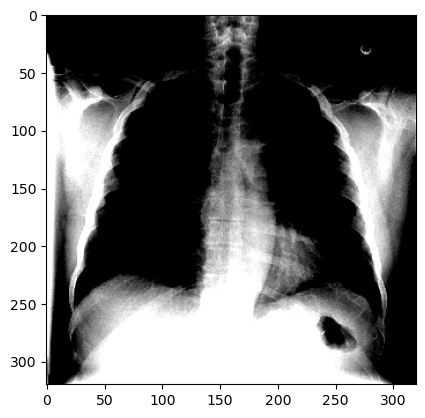

In [13]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

<a name='3'></a>
## 3. Développement du modèle

Nous allons maintenant passer à la formation et au développement du modèle. Avant de procéder à la formation d'un réseau neuronal, nous devons cependant relever quelques défis pratiques. Le premier est le déséquilibre des classes.

<a name='3-1'></a>
### 3.1 Traitement du déséquilibre des classes

L'un des défis que pose le travail avec des ensembles de données de diagnostic médical est le grand déséquilibre des classes présent dans ces ensembles de données. Traçons la fréquence de chacune des étiquettes dans notre ensemble de données :

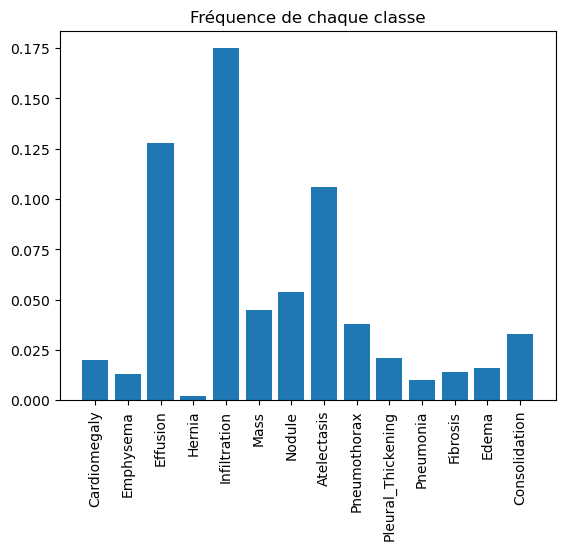

In [14]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Fréquence de chaque classe")
plt.show()

Nous pouvons voir sur ce graphique que la prévalence des cas positifs varie de manière significative entre les différentes pathologies. (Ces tendances reflètent également celles de l'ensemble complet de données). 
* La pathologie `Hernia` présente le plus grand déséquilibre avec une proportion de cas d'entraînement positifs d'environ 0,2%. 
* Mais même la pathologie `Infiltration`, qui a le moins de déséquilibre, a seulement 17,5% des cas d'entraînement étiquetés positifs.

Idéalement, nous devrions former notre modèle en utilisant un ensemble de données équilibré de sorte que les cas d'entraînement positifs et négatifs contribuent de manière égale à la perte. 

Si nous utilisons une fonction de perte d'entropie croisée normale avec un ensemble de données fortement déséquilibré, comme c'est le cas ici, l'algorithme sera incité à donner la priorité à la classe majoritaire (c'est-à-dire négative dans notre cas), puisqu'elle contribue davantage à la perte. 

### Calculer les fréquences des classes

In [15]:
def compute_class_freqs(labels):
    N = np.shape(labels)[0]
    
    positive_frequencies = np.sum(labels, axis = 0)/N
    negative_frequencies = 1 - positive_frequencies
    
    return positive_frequencies, negative_frequencies

In [16]:
compute_class_freqs_test(compute_class_freqs)

Labels:
[[1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]
 [1 0 1]]

Pos Freqs:  [0.8 0.4 0.8]
Neg Freqs:  [0.2 0.6 0.2] 

 All tests passed.


Maintenat on calcule les fréquences pour notre ensemble d'apprentissage.

In [17]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

/var/folders/dw/_jhdnlb11cn9nfscrtbfw1gc0000gn/T/ipykernel_43747/2978771470.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)


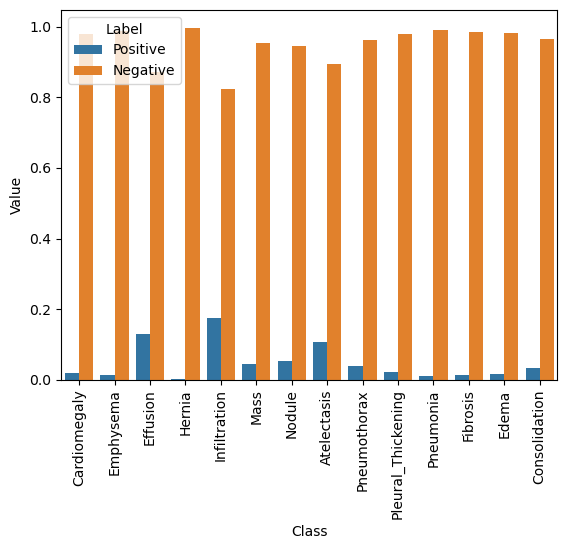

In [18]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

Comme nous le voyons dans le graphique ci-dessus, les contributions des cas positifs sont significativement plus faibles que celles des cas négatifs. Cependant, nous voulons que les contributions soient égales. Une façon d'y parvenir est de multiplier chaque exemple de chaque classe par un facteur de pondération spécifique à la classe, $w_{pos}$ et $w_{neg}$, de sorte que la contribution globale de chaque classe soit la même. 

Pour ce faire, nous voulons 

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

ce que nous pouvons faire simplement en prenant 

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

De cette façon, nous équilibrerons la contribution des étiquettes positives et négatives.

In [19]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

Vérifions cela en représentant graphiquement les deux contributions l'une à côté de l'autre :

/var/folders/dw/_jhdnlb11cn9nfscrtbfw1gc0000gn/T/ipykernel_43747/4211278599.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}


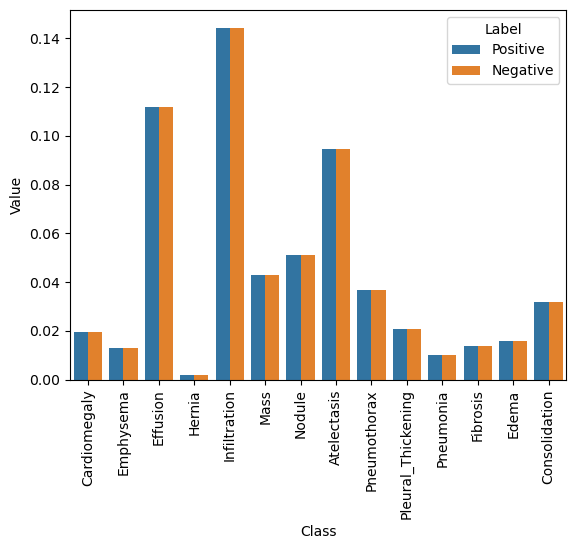

In [20]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

Comme le montre la figure ci-dessus, en appliquant ces pondérations, les étiquettes positives et négatives de chaque classe auront la même contribution globale à la fonction de perte. Implémentons maintenant une telle fonction de perte. 

Après avoir calculé les pondérations, notre perte pondérée finale pour chaque cas de formation sera la suivante 

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

### Obtention la perte pondérée

In [22]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        loss = 0.0

        for i in range(len(pos_weights)):
            loss += K.mean(-(pos_weights[i] * y_true[:,i] * K.log(y_pred[:,i] + epsilon) +
                            neg_weights[i] * (1 - y_true[:,i]) * K.log(1 - y_pred[:,i] + epsilon)))
        return loss
    
    return weighted_loss


In [23]:
epsilon = 1

sess = K.get_session()
get_weighted_loss_test(get_weighted_loss, epsilon, sess)

2023-12-11 16:22:30.483462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 16:22:30.499346: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


y_true:
[[1. 1. 1.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 0. 1.]]

w_p:
[0.25 0.25 0.5 ]

w_n:
[0.75 0.75 0.5 ]

y_pred_1:
[[0.7 0.7 0.7]
 [0.7 0.7 0.7]
 [0.7 0.7 0.7]
 [0.7 0.7 0.7]]

y_pred_2:
[[0.3 0.3 0.3]
 [0.3 0.3 0.3]
 [0.3 0.3 0.3]
 [0.3 0.3 0.3]]

If you weighted them correctly, you'd expect the two losses to be the same.
With epsilon = 1, your losses should be, L(y_pred_1) = -0.4956203 and L(y_pred_2) = -0.4956203

Your outputs:

L(y_pred_1) =  -0.4956203
L(y_pred_2) =  -0.49562037
Difference: L(y_pred_1) - L(y_pred_2) =  5.9604645e-08 

 All tests passed.


<a name='3-2'></a>
### 3.2 DenseNet121

Ensuite, nous utiliserons un modèle pré-entraîné [DenseNet121] (https://www.kaggle.com/pytorch/densenet121) que nous pouvons charger directement depuis Keras, puis nous ajouterons deux couches par-dessus :
1. Une couche `GlobalAveragePooling2D` pour obtenir la moyenne des dernières couches de convolution de DenseNet121.
2. Une couche `Dense` avec une activation  `sigmoid`` pour obtenir les logits de prédiction pour chacune de nos classes.

Nous pouvons définir notre fonction de perte personnalisée pour le modèle en spécifiant le paramètre `loss` dans la fonction `compile()` même).

In [24]:
base_model = DenseNet121(weights='models/nih/densenet.hdf5', include_top=False)

x = base_model.output

# ajouter une couche de mise en commun de la moyenne spatiale globale
x = GlobalAveragePooling2D()(x)

# et une couche logistique
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

<a name='4'></a>
## 4. Entraînement

Avec notre modèle prêt pour l'entraînement, nous allons utiliser la fonction `model.fit()` dans Keras pour entraîner notre modèle. 
- Nous nous entraînons sur un petit sous-ensemble de l'ensemble de données (~1%).  
- Donc, ce qui nous intéresse à ce stade est de s'assurer que la perte sur l'ensemble d'entraînement est décroissante.

L'entraînement pouvant prendre un temps considérable, nous avons choisi de ne pas entraîner le modèle ici, mais plutôt de charger un ensemble de poids pré-entraînés dans la section suivante. Cependant, vous pouvez utiliser le code ci-dessous pour vous entraîner à construire localement le modèle localement sur votre machine.

# Code risqué
```python
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 3)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Courbe perte en apprentissage")
plt.show()
```

<a name='4-1'></a>
### 4.1 Entraînement sur ensemble de données important

Étant donné que l'ensemble de données original a une taille de plus de 40 Go et que le processus d'entraînement sur l'ensemble de données complet prend quelques heures, nous avons entraîné le modèle sur une machine équipée d'un GPU et on a obtenu le fichier de poids de notre modèle (avec une taille de lot de 32) à utiliser pour le reste de ce travail. 

L'architecture de notre modèle pré-entraîné est exactement la même, mais nous avons utilisé quelques "callbacks" Keras utiles pour cet entraînement. Prenez le temps de lire ces rappels, car ils seront très utiles pour gérer les sessions d'apprentissage de longue durée :

1. Vous pouvez utiliser le callback `ModelCheckpoint` pour surveiller la métrique `val_loss` de votre modèle et garder un instantané de votre modèle à ce point. 
2. Vous pouvez utiliser le `TensorBoard` pour utiliser  Tensorflow Tensorboard pour surveiller vos exécutions en temps réel. 
3. Vous pouvez utiliser le `ReduceLROnPlateau` pour diminuer lentement le taux d'apprentissage de votre modèle quand il cesse de s'améliorer sur une métrique telle que `val_loss` pour affiner le modèle dans les dernières étapes de l'entraînement.
4. Vous pouvez utiliser le rappel  (callback) `EarlyStopping` pour arrêter le travail d'apprentissage lorsque votre modèle cesse de s'améliorer relativement à la perte de validation. Vous pouvez définir une valeur de `patience` qui est le nombre d'époques où le modèle ne s'améliore pas, après quoi l'apprentissage est terminée. Ce callback peut également restaurer les poids de la meilleure métrique à la fin de l'apprentissage de votre modèle.

Vous pouvez vous renseigner sur ces callbacks et d'autres callbacks Keras utiles [ici] (https://keras.io/callbacks/).

In [25]:
model.load_weights("models/nih/pretrained_model.h5")

<a name='5'></a>
## 5. Prédiction et Evaluation

Maintenant que nous avons un modèle, évaluons-le en utilisant notre ensemble de test. Nous pouvons facilement utiliser la fonction `predict_generator` pour générer les prédictions pour les images de notre ensemble de test.

In [26]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

/var/folders/dw/_jhdnlb11cn9nfscrtbfw1gc0000gn/T/ipykernel_43747/2146632228.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))
/Users/yassineanas/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


<a name='5-1'></a>
### 5.1 Courbes ROC et AUROC

Pour l'instant, nous allons calculer une métrique appelée AUC (Area Under the Curve) à partir de la courbe ROC ([Receiver Operating Characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)). Cette mesure est également appelée valeur AUROC, mais vous verrez ces trois termes en référence à la technique, et ils sont souvent utilisés de manière presque interchangeable. 

Pour l'instant, ce que vous devez savoir pour interpréter le graphique, c'est qu'une courbe qui se trouve plus à gauche et en haut a plus de "surface" sous elle, et indique que le modèle est plus performant.

Nous allons utiliser la fonction `util.get_roc_curve()` qui vous a été fournie dans `util.py`. Regardez cette fonction et notez l'utilisation des fonctions de la bibliothèque `sklearn` pour générer les courbes ROC et les valeurs AUROC pour notre modèle. 

- [roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
- [roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

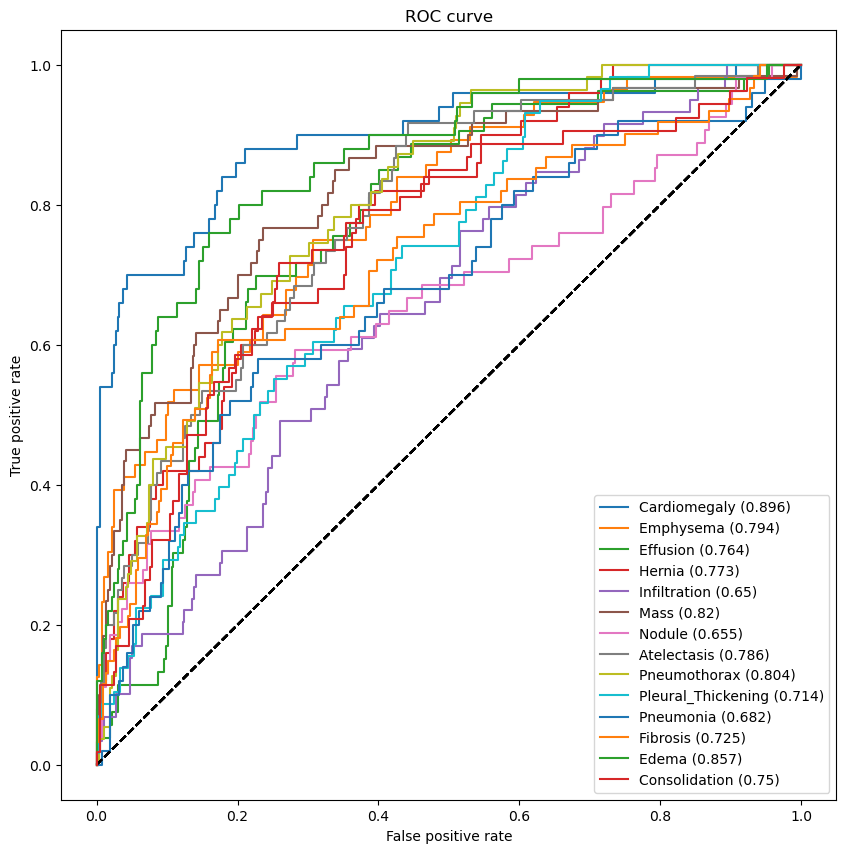

In [27]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)